# Install and import openpifpaf and prediction model


In [ ]:
!pip install --upgrade torch
!pip install --upgrade torchtext
!pip install --upgrade torchvision
!pip install --upgrade openpifpaf

     |████████████████████████████████| 224 kB 9.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 166 kB 61.7 MB/s 
     |████████████████████████████████| 1.4 MB 62.3 MB/s 
  Created wheel for openpifpaf: filename=openpifpaf-0.13.3-cp37-cp37m-linux_x86_64.whl size=8277145 sha256=587b9e7d429793cd162b60cbe03699519719ec87291e3ca902a4f544509cbe02
  Stored in directory: /root/.cache/pip/wheels/23/47/d0/323157ebf9020a79369d7c33f500b62b8c7e1a5381fcf036ed
  Created wheel for pysparkling: filename=pysparkling-0.6.1-py3-none-any.whl size=187580 sha256=ee7b91ab3b8e6be166d9fd0d596e178c60ba5c2c905da8cba28a6617cc4b05b9
  Stored in directory: /root/.cache/pip/wheels/c8/2e/ac/5336e8ec240e9895bf4f142026f16d0d442af578d339c44aa0
Successfully built openpifpaf pysparkling


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torchvision
import torchtext
import io
import openpifpaf
import PIL
import requests
import cv2
from google.colab.output import eval_js
# import dependencies
from IPython.display import display, Javascript, Image, clear_output
from base64 import b64decode, b64encode
import html
import time

from torch.nn import functional as F
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(F'Device used: {device}')

print('OpenPifPaf version', openpifpaf.__version__)

Device used: cuda:0
OpenPifPaf version 0.13.3


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!gdown --id 1iYxlkO_RZJ_6iL6wdIbfjl8VprLlFp1c



/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iYxlkO_RZJ_6iL6wdIbfjl8VprLlFp1c
To: /content/pose_classification_simplified.ckpt
100% 2.98k/2.98k [00:00<00:00, 5.68MB/s]


# Schematics

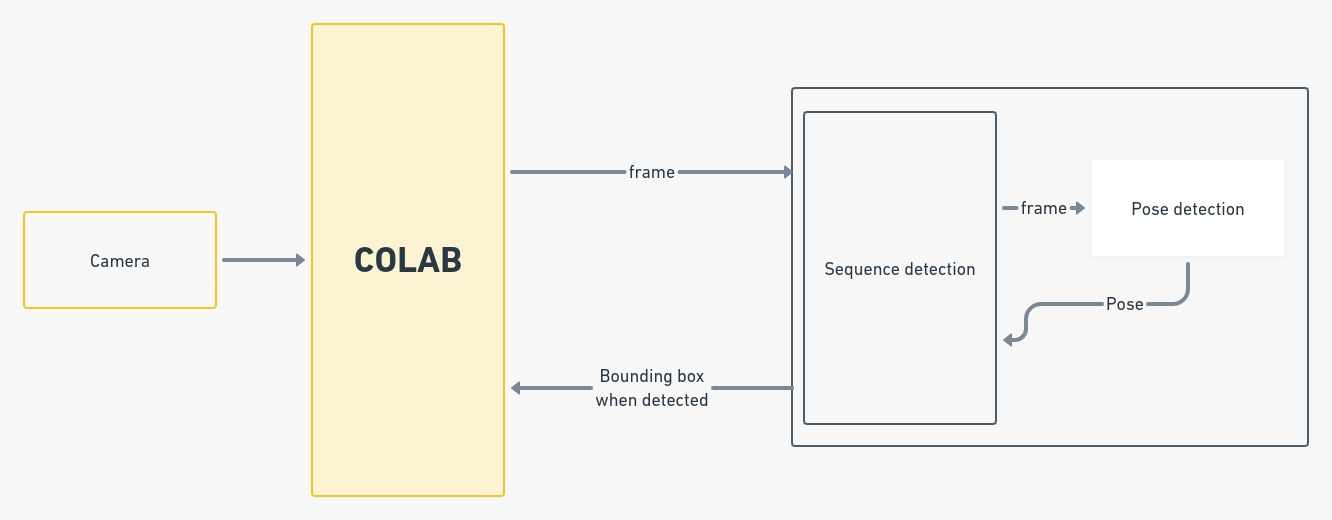


## Pose estimation:
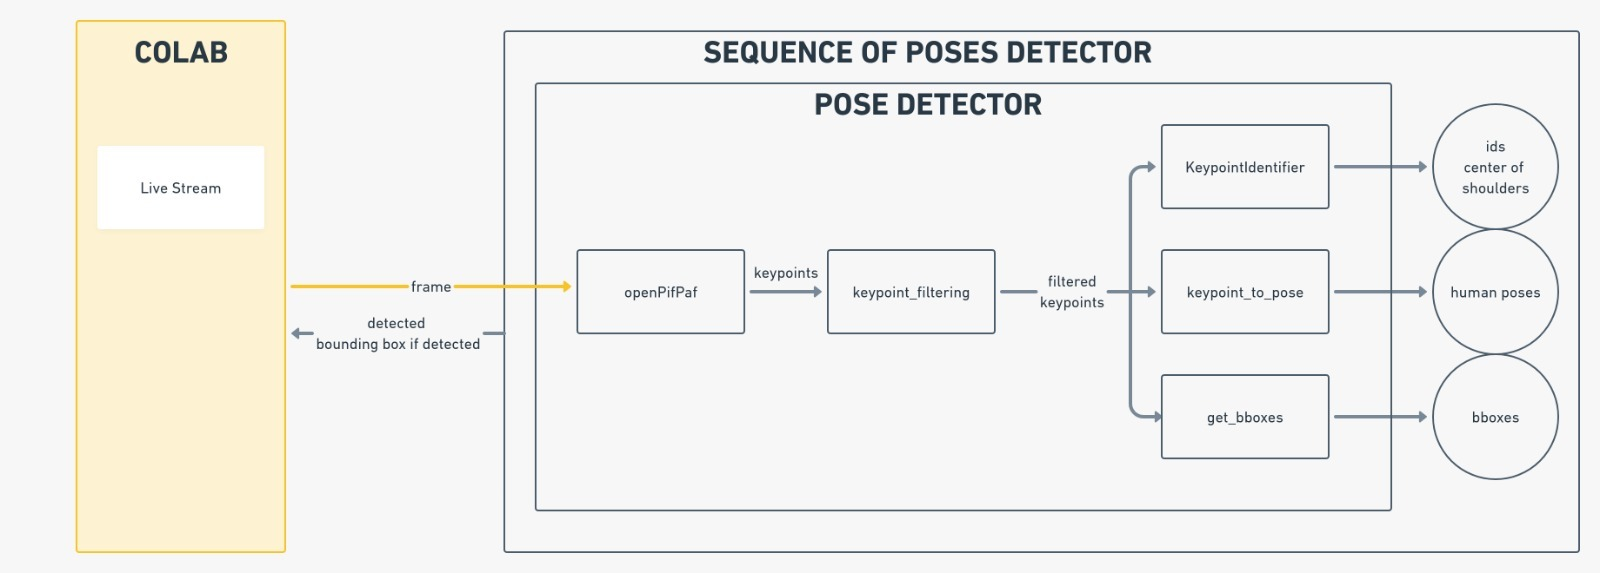

## Classes
### KeypointToPoseNet : the deep net module, keypoints -> positions

In [ ]:
class KeypointToPoseNet(torch.nn.Module):
    """Fully connected linear net to classify human pose from keypoints"""
    def __init__(self, n_feature, n_output):
        super(KeypointToPoseNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, 32)
        self.fc3 = torch.nn.Linear(32, n_output)


    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### KeypointIdentifier : Creates an unique identifier/person detected, in order to track them through time

In [ ]:
class KeypointIdentifier(object):
    """Gives an unique id for every detected person"""
    def __init__(self, threshold):
        self.old_predictions = None
        self.center = None
        self.id = np.array([])
        self.threshold = threshold

    def update(self, new_prediction):
        # if nothing detected, reset
        if len(new_prediction) == 0:
            self.old_predictions = None
            self.center = None
            self.id = np.array([])
        else :
            # if no predictions was done, initialize
            if self.old_predictions is None:
                self._initialize(new_prediction)
            else:
                self._update_predictions(new_prediction)

    def _initialize(self, new_prediction):
            self.old_predictions = new_prediction
            self.id = np.arange(len(new_prediction))
            self.center = np.zeros((len(new_prediction),2))
            for i in self.id:
                self.center[i] = new_prediction[i].data[5:7,:2].mean(axis=0)

    def _update_predictions(self, new_prediction):
        new_center = np.zeros((len(new_prediction),2))
        new_id = np.arange(max(self.id)+1, max(self.id)+1 + len(new_prediction))
        for i in range(len(new_prediction)):
            new_center[i] = new_prediction[i].data[5:7,:2].mean(axis=0)
            for idx, center in enumerate(self.center):
                if np.linalg.norm(new_center[i] - center) < self.threshold:
                    new_id[i] = self.id[idx]
        self.id = new_id
        self.center = new_center


### PoseDetector: handles all the pose detection

In [ ]:
class PoseDetector(object):
    """Given an image, it detects humans and their body position"""
    def __init__(self, n_feature, n_output, checkpoint_path, simple_mode=True, model_based=False):
        self.keypoint_to_pose_net = KeypointToPoseNet(n_feature=n_feature, n_output=n_output).cuda(device)
        self.keypoint_to_pose_net.load_state_dict(torch.load(checkpoint_path))

        self.keypoint_identifier = KeypointIdentifier(100)

        self.openpifpaf_predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k30')

        self.simple_mode = simple_mode
        self.model_based = model_based

        self.openpifpaf_predictions = None
        self.openpifpaf_predictions_filtered = None
        self.pose_predictions = None
        self.identifiers = None
        self.centers = None
        self.bboxes = None


    def detection(self, frame):
        #openpifpaf does prediction
        self.openpifpaf_predictions, _, _ = self.openpifpaf_predictor.numpy_image(frame)
        #filter the predictions (have to see at least both wrists, elbows and shoulders)
        self._keypoint_filtering()
        # match an unique identifier to each element
        self.keypoint_identifier.update(self.openpifpaf_predictions_filtered)
        # predicts the pose of each person
        self._keypoints_to_pose()
        # get bounding boxes
        self._get_bboxes()


    def _keypoints_to_pose(self):
        n_predictions = len(self.openpifpaf_predictions_filtered)
        self.pose_predictions = np.zeros(n_predictions, dtype=int)
        if self.simple_mode:
            ind = np.arange(5,9)
        else:
            ind = np.arange(5,11)

        if self.model_based:
            lim1 = [3.3, 2.7, 2.3, 1.7, 3.2, 2.7, 3.2, 2.7] # angle limits for pose 1 (L)
            lim2 = [2.3, 1.7, 3.3, 2.7, 3.2, 2.7, 3.2, 2.7] # angle limits for pose 2 (invL)
            for i in range(n_predictions):
                p = self.openpifpaf_predictions_filtered[i].data[ind]
                if self.simple_mode:
                    v = [p[0]-p[1],p[2]-p[0],p[3]-p[1]]
                    v = np.array([v[j] / np.linalg.norm(v[j]) for j in range(len(v))])
                    a1 = np.pi - np.arccos(np.dot(v[1],v[0])) # rsh lsh lel
                    a2 = np.pi - np.arccos(np.dot(-v[2],v[0])) # lsh rsh rel
                    if p[0,1] < p[2,1]:
                        a1 = 2*np.pi - a1
                    if p[1,1] < p[3,1]:
                        a2 = 2*np.pi - a2
                    a = [a1, a2]
                    if a[0] < lim1[0] and a[0] > lim1[1] and \
                      a[1] < lim1[2] and a[1] > lim1[3]:
                        self.pose_predictions[i] = 1
                    elif a[0] < lim2[0] and a[0] > lim2[1] and \
                      a[1] < lim2[2] and a[1] > lim2[3]:
                        self.pose_predictions[i] = 2
                    else:
                      self.pose_predictions[i] = 0
                else:
                    v = [p[0]-p[1],p[2]-p[0],p[4]-p[2],p[3]-p[1],p[5]-p[3]]
                    v = np.array([v[j] / np.linalg.norm(v[j]) for j in range(len(v))])
                    a1 = np.pi - np.arccos(np.dot(v[1],v[0])) # rsh lsh lel
                    a2 = np.pi - np.arccos(np.dot(-v[3],v[0])) # lsh rsh rel
                    a3 = np.pi - np.arccos(np.dot(v[2],v[1])) # lsh lel lwr
                    a4 = np.pi - np.arccos(np.dot(v[4],v[3])) # rsh rel rwr
                    if p[0,1] < p[2,1]:
                        a1 = 2*np.pi - a1
                    if p[1,1] < p[3,1]:
                        a2 = 2*np.pi - a2
                    if p[2,1] < p[4,1]:
                        a3 = 2*np.pi - a3
                    if p[3,1] < p[5,1]:
                        a4 = 2*np.pi - a4
                    a = [a1, a2, a3, a4]
                    if a[0] < lim1[0] and a[0] > lim1[1] and \
                      a[1] < lim1[2] and a[1] > lim1[3] and \
                      a[2] < lim1[4] and a[2] > lim1[5] and \
                      a[3] < lim1[6] and a[3] > lim1[7]:
                        self.pose_predictions[i] = 1
                    elif a[0] < lim2[0] and a[0] > lim2[1] and \
                      a[1] < lim2[2] and a[1] > lim2[3]and \
                      a[2] < lim2[4] and a[2] > lim2[5] and \
                      a[3] < lim2[6] and a[3] > lim2[7]:
                        self.pose_predictions[i] = 2
                    else:
                      self.pose_predictions[i] = 0

        else:           
          for i in range(n_predictions):
              keypoints = self.openpifpaf_predictions_filtered[i].data[ind]
              keypoints = keypoints[:,:2].copy()
              keypoints -= keypoints.mean(axis=0) 
              keypoints /= keypoints.std(axis=0)
              keypoints = keypoints.reshape(1,-1)
              _, pred = torch.max(F.softmax(self.keypoint_to_pose_net(torch.from_numpy(keypoints.astype(np.float32)).cuda(device))).data, dim=1)
              self.pose_predictions[i] = pred.int().cpu()

    def _get_bboxes(self):
        n_predictions = len(self.openpifpaf_predictions_filtered)
        self.bboxes = np.zeros((n_predictions,4))

        for i in range(n_predictions):
            self.bboxes[i] = self.openpifpaf_predictions_filtered[i].bbox()


    def _keypoint_filtering(self):
        self.openpifpaf_predictions_filtered = copy.deepcopy(self.openpifpaf_predictions)

        def fn(prediction):
          if self.simple_mode:
            return (prediction.data[5:9,2] > 0.5).all()
          else:
            return (prediction.data[5:11,2] > 0.5).all()

        self.openpifpaf_predictions_filtered =  list(filter(fn, self.openpifpaf_predictions_filtered))

## Sequence detector: detects sequence of poses

In [ ]:
class SequenceDetector(object):
    """Given an image, it detects a sequence of poses"""
    def __init__(self, n_feature, n_output, checkpoint_path, sequence, reset_time, simple_mode=True, model_based=False, face_bbox=False, face_tightness=1):
        self.pose_detector = PoseDetector(n_feature=n_feature, n_output=n_output, checkpoint_path=checkpoint_path, simple_mode=simple_mode, model_based=model_based)
        self.sequence = sequence
        self.reset_time = reset_time
        self.face_bbox = face_bbox
        self.face_tightness = face_tightness

        self.i_seq = np.array([]) # array containing position in sequence
        self.id_prev = np.array([]) # array containing id of prediction
        self.t_prev = np.array([]) # array containing time since last corresponding pose detected in sequence
        self.bbox = np.array([]) # bounding box 

    def detection(self, frame): 
        self.pose_detector.detection(frame=frame)
        if self.id_prev.size == 0:
            self.reset()
        else:
            self.update()
            
    def update_att(self):
        # delete unecessary i_seq, id_prev if id_prev is not in pose_detector's id list
        self.id_prev, _, idx = np.intersect1d(self.pose_detector.keypoint_identifier.id,self.id_prev,return_indices=True)
        if idx.size == 0:
            self.i_seq = np.array([0])
            self.t_prev = time.time()
        else:
            self.i_seq = self.i_seq[idx]
            self.t_prev = self.t_prev[idx]
        # add new ids
        if len(self.id_prev) < len(self.pose_detector.keypoint_identifier.id):
            self.i_seq = np.append(self.i_seq, np.zeros(len(self.pose_detector.keypoint_identifier.id) - len(self.id_prev)))
            self.t_prev = np.append(self.t_prev, np.repeat(time.time(),len(self.pose_detector.keypoint_identifier.id) - len(self.id_prev)))
            self.id_prev = np.array(self.pose_detector.keypoint_identifier.id)

    def reset(self):
        if len(self.pose_detector.pose_predictions) == 0:
            self.i_seq = np.array([0])
            self.id_prev = np.array([0])
            self.t_prev = np.array([time.time()])
        else:
            self.i_seq = np.zeros(len(self.pose_detector.pose_predictions))
            self.id_prev = self.pose_detector.keypoint_identifier.id
            self.t_prev = np.repeat(time.time(),len(self.pose_detector.pose_predictions))
    
    def get_bbox(self,i):
        if self.face_bbox and not (self.pose_detector.openpifpaf_predictions_filtered[i].data[:3,:2]==0).any(): # if eyes and nose not detected, defaults to regular bbox
            face = self.pose_detector.openpifpaf_predictions_filtered[i].data[:5,:2]
            d_eyes = np.linalg.norm(face[1] - face[2])
            if (face[3]==0.0).any() and (face[4]==0.0).any(): # no ears
                d_ears = 2*d_eyes
            elif (face[3]==0.0).any(): # no left ear
                d_ears = np.linalg.norm(face[1] - face[4])
            elif (face[4]==0.0).any(): # no right ear
                d_ears = np.linalg.norm(face[2] - face[3])
            else:
                d_ears = np.linalg.norm(face[3] - face[4])
            w = (d_ears)*self.face_tightness
            h = (d_ears + d_eyes)*self.face_tightness
            x = face[0,0] - 1/2*w
            y = face[0,1] - 1/2*h
            self.bbox = [x,y,w,h]
        else:
            self.bbox = self.pose_detector.bboxes[i]
    
    def update(self):
        self.update_att()
        for i in range(len(self.id_prev)): 
            pose = self.pose_detector.pose_predictions[i]
            # check pose
            if pose != 0:
                if pose == self.sequence[int(self.i_seq[i])]: # reached next in sequence
                    self.i_seq[i] += 1
                    self.t_prev[i] = time.time()
                    if int(self.i_seq[i]) >= len(self.sequence): # reached end of sequence
                        self.get_bbox(i)
                        self.reset()
                        return
                elif self.i_seq[i] >= 0 and pose == self.sequence[int(self.i_seq[i])-1]: # same pose
                    self.t_prev[i] = time.time()
                else: # different pose
                    if time.time() - self.t_prev[i] > self.reset_time:
                        self.i_seq[i] = 0
                        self.t_prev[i] = time.time()
            else: # rien detected
                if time.time() - self.t_prev[i] > self.reset_time:
                        self.i_seq[i] = 0
                        self.t_prev[i] = time.time()

## Helper functions (Javascript sorcery)

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img


# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

##Visualization

In [ ]:
positions_names = ["rien", "L", "invL"]
n_positions = 3
sequence = [1, 2] 
sequence_txt = 'Sequence: '
for i in sequence:
  sequence_txt += positions_names[i] + ' '
print(sequence_txt)
reset_time = 10
sequence_detector = SequenceDetector(n_feature=8, n_output=n_positions, checkpoint_path="pose_classification_simplified.ckpt", sequence=sequence, reset_time=reset_time, face_bbox=True, simple_mode=True, model_based=False) # Try face_bbox=False for full body bbox


# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
#count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    sequence_detector.detection(img)



    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if len(sequence_detector.bbox) != 0:
        bbox = np.array(sequence_detector.bbox).astype(int)
        bbox_array = cv2.rectangle(bbox_array,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(255,0,0), 2)



    # get face region coordinates
    #faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    #for (x,y,w,h) in faces:

    pil_im = PIL.Image.fromarray(img)
    im = np.asarray(pil_im)

    # predictions, gt_anns, image_meta = predictor.pil_image(pil_im)

    # annotation_painter = openpifpaf.show.AnnotationPainter()
    # with openpifpaf.show.image_canvas(im) as ax:
    #     clear_output(wait = True)
    #     annotation_painter.annotations(ax, predictions)
    #     plt.show()

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

Sequence: L invL 


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# Evaluation
Evaluation of different networks on inference speed (using colab pro).
The networks used are the same ones used in the official website's [introduction](https://openpifpaf.github.io/intro.html#introduction)

In [ ]:
%%bash
mkdir data-mscoco
cd data-mscoco

wget -q -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
wget -q -nc http://images.cocodataset.org/annotations/image_info_test2017.zip
unzip -q -n annotations_trainval2017.zip
unzip -q -n image_info_test2017.zip

mkdir images
cd images
wget -q -nc http://images.cocodataset.org/zips/val2017.zip
wget -q -nc http://images.cocodataset.org/zips/train2017.zip
wget -q -nc http://images.cocodataset.org/zips/test2017.zip
unzip -q -n val2017.zip
unzip -q -n train2017.zip
unzip -q -n test2017.zip

**mobilenetv3small**


In [ ]:
!python -m openpifpaf.benchmark --checkpoint mobilenetv3small

**mobilenetv3large**


In [ ]:
!python -m openpifpaf.benchmark --checkpoint mobilenetv3large

**resnet50**

In [ ]:
!python -m openpifpaf.benchmark --checkpoint resnet50

**shufflenetv2k16**

In [ ]:
!python -m openpifpaf.benchmark --checkpoint shufflenetv2k16

**shufflenetv2k30**

In [ ]:
!python -m openpifpaf.benchmark --checkpoint shufflenetv2k30